# Image Data Preprocessing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from sklearn.model_selection import train_test_split
import shutil

### Define Data Paths

In [2]:
data_dir = 'data/raw' # Raw data
processed_dir = 'data/processed' # Processed data

# Create processed data directory 
os.makedirs(os.path.join(processed_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(processed_dir, 'test'), exist_ok=True)

# Get class names from folder names
class_names = os.listdir(data_dir)
class_names = [d for d in class_names if os.path.isdir(os.path.join(data_dir, d))]
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

Classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Number of classes: 10


### Count per class

In [3]:
# Rename images in each class folder to <class>_1.ext, <class>_2.ext, ...
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    images.sort()  # deterministic ordering

    # 1) Move to temporary names to avoid collisions
    tmp_paths = []
    for i, fname in enumerate(images, 1):
        src = os.path.join(class_path, fname)
        ext = os.path.splitext(fname)[1].lower()
        tmp = os.path.join(class_path, f".tmp_{i}{ext}")
        try:
            os.rename(src, tmp)
            tmp_paths.append(tmp)
        except Exception as e:
            print(f"Failed to rename {src} -> {tmp}: {e}")

    # 2) Rename temp files to the final desired names
    for i, tmp_path in enumerate(tmp_paths, 1):
        ext = os.path.splitext(tmp_path)[1]
        final = os.path.join(class_path, f"{class_name}_{i}{ext}")
        try:
            os.rename(tmp_path, final)
        except Exception as e:
            print(f"Failed to rename {tmp_path} -> {final}: {e}")

    print(f"Renamed {len(tmp_paths)} files in '{class_name}'")

# Update and display counts after renaming
class_counts = {cn: len([f for f in os.listdir(os.path.join(data_dir, cn)) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))]) 
                for cn in class_names}

for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Renamed 2106 files in 'butterfly'
Renamed 1663 files in 'cat'
Renamed 3088 files in 'chicken'
Renamed 1845 files in 'cow'
Renamed 4859 files in 'dog'
Renamed 1442 files in 'elephant'
Renamed 2627 files in 'horse'
Renamed 1818 files in 'sheep'
Renamed 4810 files in 'spider'
Renamed 1859 files in 'squirrel'
butterfly: 2106 images
cat: 1663 images
chicken: 3088 images
cow: 1845 images
dog: 4859 images
elephant: 1442 images
horse: 2627 images
sheep: 1818 images
spider: 4810 images
squirrel: 1859 images


### Sample Images

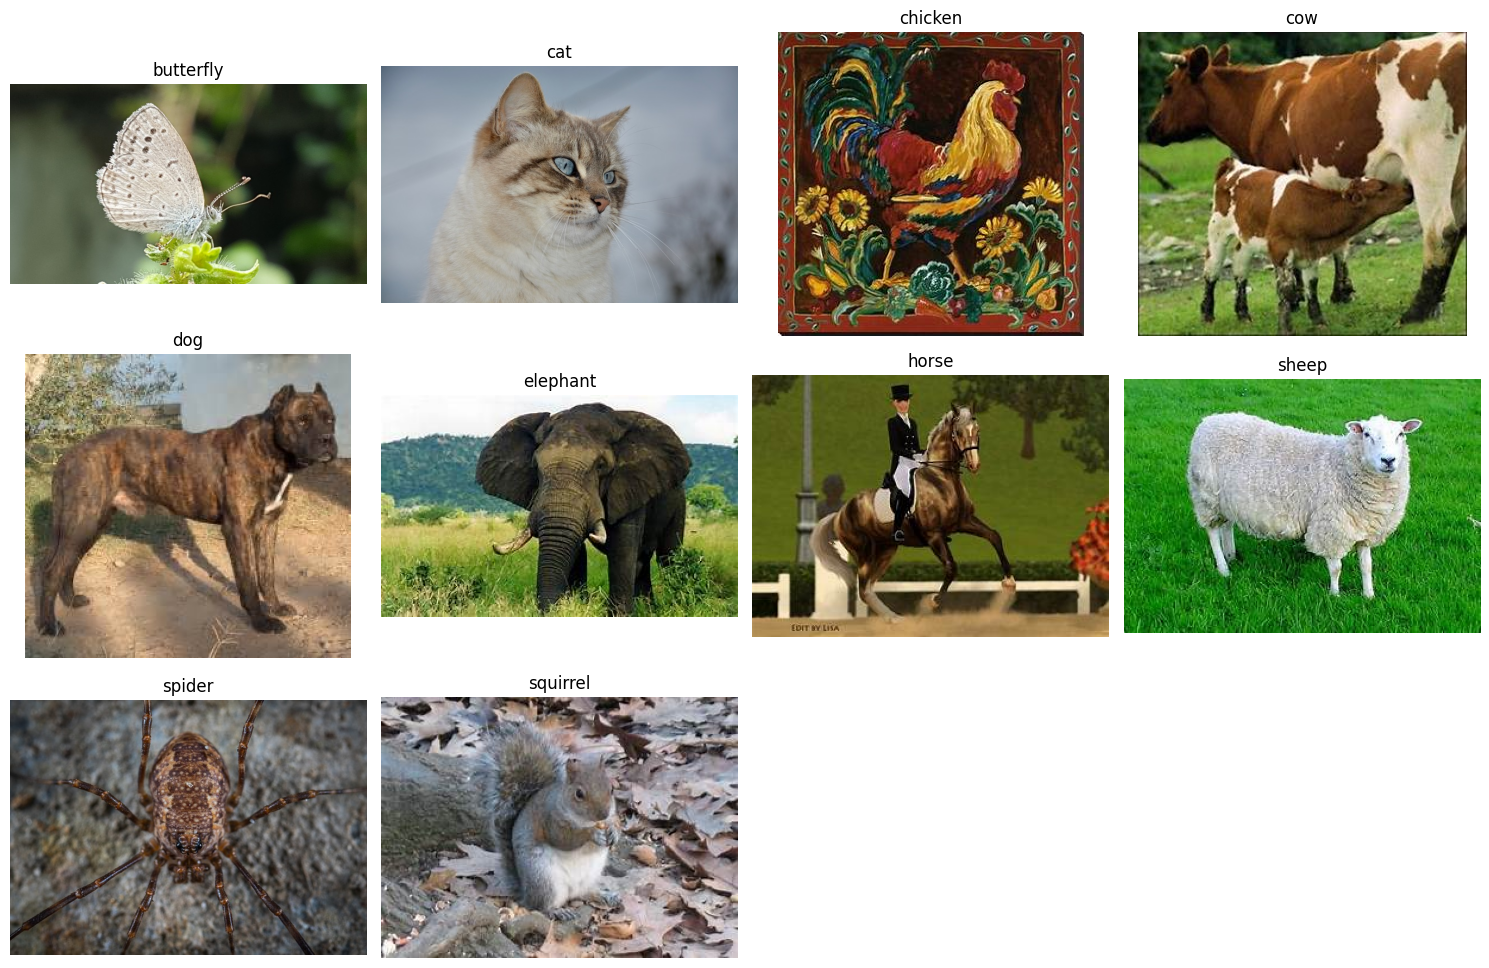

In [4]:
plt.figure(figsize=(15, 10))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(data_dir, class_name)
    images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Get a random image
    if images:
        img_path = os.path.join(class_path, random.choice(images))
        img = Image.open(img_path)
        
        plt.subplot(3, 4, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

plt.tight_layout()
plt.show()

### Train - Test Split

In [5]:
# Split data into train and test sets
def split_data(data_dir, class_names, test_size=0.2, random_state=30):
    all_files = []
    all_labels = []
    
    # Collect all file paths and their corresponding labels
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        files = [os.path.join(class_path, f) for f in os.listdir(class_path) 
                if f.endswith(('.jpg', '.jpeg', '.png'))]
        labels = [i] * len(files)  # Assign numeric label to each class
        
        all_files.extend(files)
        all_labels.extend(labels)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        all_files, all_labels, test_size=test_size, 
        stratify=all_labels, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Perform the split
X_train, X_test, y_train, y_test = split_data(data_dir, class_names)

# Print split information
print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")

# Check class distribution in train and test sets
train_dist = {i: y_train.count(i) for i in range(len(class_names))}
test_dist = {i: y_test.count(i) for i in range(len(class_names))}

print("\nClass distribution in training set:")
for i, count in train_dist.items():
    print(f"{class_names[i]}: {count} images")

print("\nClass distribution in testing set:")
for i, count in test_dist.items():
    print(f"{class_names[i]}: {count} images")

Training set: 20893 images
Testing set: 5224 images

Class distribution in training set:
butterfly: 1685 images
cat: 1330 images
chicken: 2470 images
cow: 1476 images
dog: 3887 images
elephant: 1154 images
horse: 2102 images
sheep: 1454 images
spider: 3848 images
squirrel: 1487 images

Class distribution in testing set:
butterfly: 421 images
cat: 333 images
chicken: 618 images
cow: 369 images
dog: 972 images
elephant: 288 images
horse: 525 images
sheep: 364 images
spider: 962 images
squirrel: 372 images


### Save Processed Data

In [6]:
# Create directory structure for processed data
def create_directories(processed_dir, class_names):
    """Create directories for processed data"""
    # Create train and test directories for each class
    for split in ['train', 'test']:
        split_dir = os.path.join(processed_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        
        for class_name in class_names:
            class_dir = os.path.join(split_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
    
    print(f"Created directory structure in {processed_dir}")

# Process and save images
def save_processed_data(X_train, X_test, y_train, y_test, processed_dir, class_names, target_size=(224, 224)):
    """Process and save images to their respective directories"""
    # Create directory structure
    create_directories(processed_dir, class_names)
    
    # Function to process and save a set of images
    def process_and_save(file_paths, labels, split):
        for img_path, label in zip(file_paths, labels):
            # Get class name and create destination path
            class_name = class_names[label]
            filename = os.path.basename(img_path)
            dest_path = os.path.join(processed_dir, split, class_name, filename)
            
            # Process and save the image with resizing
            try:
                img = Image.open(img_path)
                # Convert grayscale to RGB if needed
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                # Resize to target size
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                # Save the resized image
                img.save(dest_path)
            except Exception as e:
                print(f"Error saving {img_path}: {e}")
    
    # Process and save training data
    process_and_save(X_train, y_train, 'train')
    print(f"Saved {len(X_train)} training images")
    
    # Process and save testing data
    process_and_save(X_test, y_test, 'test')
    print(f"Saved {len(X_test)} testing images")

# Save the processed data
save_processed_data(X_train, X_test, y_train, y_test, processed_dir, class_names)

# Save class mapping
class_mapping = {i: name for i, name in enumerate(class_names)}
with open(os.path.join(processed_dir, 'class_mapping.txt'), 'w') as f:
    for idx, name in class_mapping.items():
        f.write(f"{idx}: {name}\n")

print(f"Saved class mapping to {os.path.join(processed_dir, 'class_mapping.txt')}")

Created directory structure in data/processed


Saved 20893 training images
Saved 5224 testing images
Saved class mapping to data/processed/class_mapping.txt
